In [1]:
import os
import sys
import pandas as pd
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic1"):
    os.chdir("..")
    print(f"Changed| to {os.getcwd()}")
from codebase import get_total_inhabitants_and_willingness
import matplotlib.pyplot as plt

Changed| to C:\Users\david\PycharmProjects\TUE\Design-of-AI-driven-business-operation
Loaded file from Excel and saved to CSV


In [2]:
within_mins = 50
punt = "highschool" # ibis, hbo_wo, mbo, basis, highschool, bus, trein
mode = "ebike" # fiets, ebike
location = "Education" # Elementary Schools, High Schools, Universities, Train - NS, Train - Local

total, total_willing = get_total_inhabitants_and_willingness(punt1=punt, mode=mode, within_mins=within_mins, location=location, verbose=True)

Loaded file from Excel and saved to CSV
Demographics and filtered dataframes do not match in length: 14296 vs 14297, ignoring missing values
Total inhabitants within 50 minutes of highschool from buurt: 17745810 of 17811291 = 99.63% of the Netherlands
Total willingness to cycle of those: 15445679 of 17745810 = 87.04%


In [3]:
#open gpkg file: "C:\Users\david\PycharmProjects\TUE\Design-of-AI-driven-business-operation\data\02_punt_tot_punt_analyse\trainstations.gpkg"
import geopandas as gpd
gdf = gpd.read_file("data/02_punt_tot_punt_analyse/trainstations.gpkg")
print(gdf.columns)
#find specific stations 187, 297, 190, 443, 459, 185, 382, 528, 186, 189])


print(gdf[gdf["train_id"] == 186])



Index(['train_id', 'name', 'fe_code', 'type', 'geometry'], dtype='object')
     train_id              name fe_code       type  \
331       186  Amsterdam Amstel     Asa  intercity   

                          geometry  
331  POINT (123013.292 484409.811)  


In [4]:
import pandas as pd
from codebase.load_data.load_demographics import load_demograhics
from codebase.load_data.load_buurt import load_buurt_data

# ----------------------------------------------------------------------
# 0. Helper: many-to-one merge (buurt kan meerdere OD-rijen hebben)
# ----------------------------------------------------------------------

def safe_merge_multi(punt_df: pd.DataFrame,
                     demo_df: pd.DataFrame,
                     punt_col="bu_code",
                     demo_col="gwb_code",
                     pop_col="a_inw") -> pd.DataFrame:

    keep = [demo_col, pop_col, "gm_naam"]          # hier extra kolommen toevoegen
    demo = demo_df[keep].copy()
    punt = punt_df.copy()

    punt[punt_col] = punt[punt_col].astype(str)
    demo[demo_col] = demo[demo_col].astype(str)

    return punt.merge(
        demo,
        left_on=punt_col,
        right_on=demo_col,
        how="inner",
        validate="many_to_one"
    )

In [5]:
# ----------------------------------------------------------------------
# 1. Dataset laden (voorbeeld: e-bike → railstations)
# ----------------------------------------------------------------------
df_demo = load_demograhics()                         # bevat o.a. kolom a_inw
df_rail = load_buurt_data("trein", mode="ebike")     # bevat reistijd_min, afstand_hemelsbreed_m, omrijdfactor

df = safe_merge_multi(df_rail, df_demo)              # heeft nu ook a_inw


Loaded file from Excel and saved to CSV


## Population weighted detour

In [6]:


# ----------------------------------------------------------------------
# 2. Vraag 1 – populatie-gewogen detour per buurt
# ----------------------------------------------------------------------
tmp = (df["omrijdfactor"] * df["a_inw"]).groupby(df["bu_code"]).sum()
pop = df.groupby("bu_code")["a_inw"].sum()
pw_detour = (tmp / pop).rename("pw_detour")          # Series
#add column with pw_detour value
df["pw_detour"] = df["bu_code"].map(pw_detour)


In [7]:
# 1) Top-10 buurtcodes met hoogste pw_detour
top10_codes = pw_detour.nlargest(10)
print(top10_codes)

import geopandas as gpd

# 1. Load GeoPackage and select name fields
geo_df = gpd.read_file(
    "data/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg"
)[["buurtcode", "buurtnaam", "gemeentenaam"]]

# 2. Rename columns
geo_df = geo_df.rename(columns={
    "buurtcode"      : "bu_code",
    "buurtnaam"      : "neighborhood_name",
    "gemeentenaam"   : "municipality_name"
})

# 3. Compute population-weighted detour per neighbourhood
detour_sum      = (df["omrijdfactor"] * df["a_inw"]).groupby(df["bu_code"]).sum()
population_sum  = df.groupby("bu_code")["a_inw"].sum()
popw_detour     = (detour_sum / population_sum).rename("popw_detour")

# 4. Extract top-10 neighbourhood codes
top10 = popw_detour.nlargest(10).reset_index()

# 5. Merge with names
top10 = top10.merge(geo_df, on="bu_code", how="left")

# 6. Display results
print(
    top10[[
        "bu_code",
        "neighborhood_name",
        "municipality_name",
        "popw_detour"
    ]]
)



bu_code
BU06770402    5.730000
BU06770401    5.555000
BU06771502    5.410000
BU06770602    5.157500
BU06770403    5.147500
BU06771503    5.015000
BU06771501    4.952500
BU06771301    4.680000
BU06771302    4.600000
BU06770902    4.588333
Name: pw_detour, dtype: float64


C:\Users\david\PycharmProjects\1bm110_data_driven_AI\.venv\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(


      bu_code         neighborhood_name municipality_name  popw_detour
0  BU06770402                      Paal             Hulst     5.730000
1  BU06770401               Kern Graauw             Hulst     5.555000
2  BU06771502                Perkpolder             Hulst     5.410000
3  BU06770602  Buitengebied Nieuw Namen             Hulst     5.157500
4  BU06770403       Buitengebied Graauw             Hulst     5.147500
5  BU06771503   Buitengebied Walsoorden             Hulst     5.015000
6  BU06771501           Kern Walsoorden             Hulst     4.952500
7  BU06771301            Kern Ossenisse             Hulst     4.680000
8  BU06771302    Buitengebied Ossenisse             Hulst     4.600000
9  BU06770902   Buitengebied Lamswaarde             Hulst     4.588333


C:\Users\david\AppData\Local\Temp\ipykernel_5272\1924690981.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["neigh_popw_detour"] * g["neigh_population"]).sum()


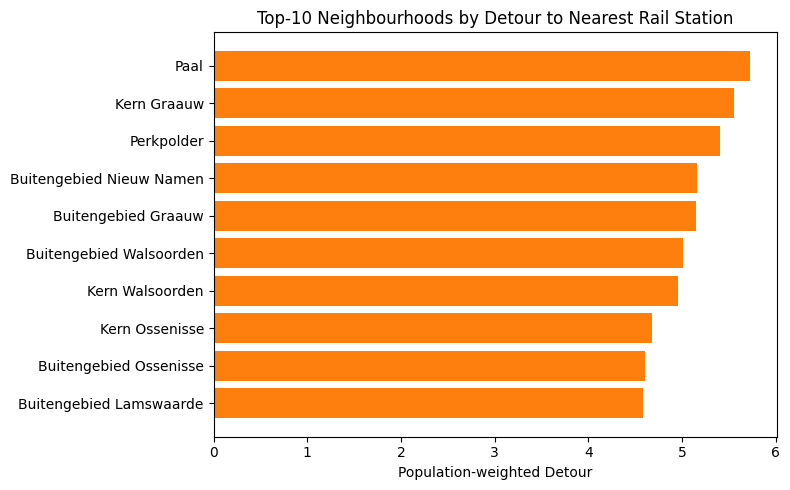

In [8]:
import pandas as pd

# 1. Prepare the neighbourhood‐level detour Series
detour_sum     = (df["omrijdfactor"] * df["a_inw"]).groupby(df["bu_code"]).sum()
population_sum = df.groupby("bu_code")["a_inw"].sum()
neigh_detour   = (detour_sum / population_sum).rename("neigh_popw_detour")

# 2. Build a neighbourhood DataFrame with code, detour, municipality, and population
#    (we assume df already has 'gm_naam' and 'a_inw' for each bu_code)
neigh_df = (
    neigh_detour
    .reset_index()                    # columns: bu_code, neigh_popw_detour
    .merge(df[["bu_code","gm_naam","a_inw"]]
            .drop_duplicates("bu_code"),
           on="bu_code", how="left")
    .rename(columns={"gm_naam":"municipality", "a_inw":"neigh_population"})
)

# 3. Compute municipality‐level weighted detour
mun_detour = (
    neigh_df
    .groupby("municipality")
    .apply(lambda g: (g["neigh_popw_detour"] * g["neigh_population"]).sum()
                       / g["neigh_population"].sum())
    .rename("mun_popw_detour")
)

# 4. Show the top‐10 municipalities
top10_mun = mun_detour.nlargest(10).reset_index()
fig, ax = plt.subplots(figsize=(8,5))
ax.barh(top10["neighborhood_name"], top10["popw_detour"], color="tab:orange")
ax.invert_yaxis()
ax.set_xlabel("Population-weighted Detour")
ax.set_title("Top-10 Neighbourhoods by Detour to Nearest Rail Station")
plt.tight_layout()
plt.savefig("results/top10_neighbourhoods_detour.png", dpi=300)
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_5272\4165591697.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["omrijdfactor"] * g["a_inw"]).sum()


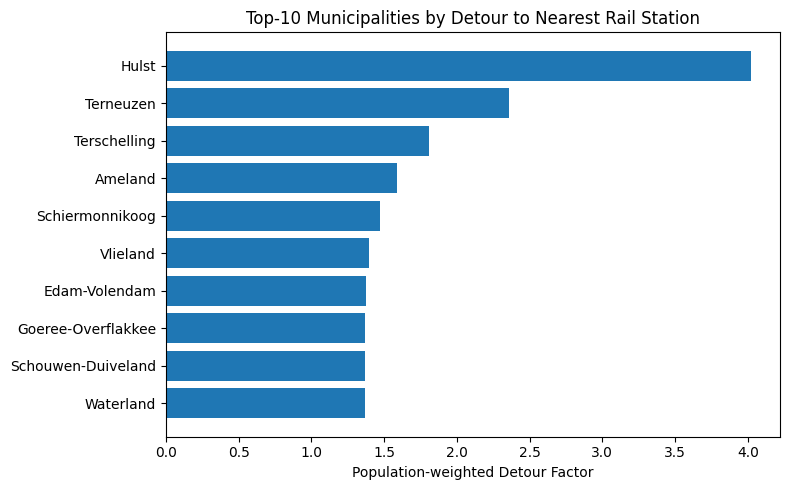

In [9]:


# 1. municipality‐level, population‐weighted detour

mun_detour = (
    df
    .groupby("gm_naam")
    .apply(lambda g: (g["omrijdfactor"] * g["a_inw"]).sum()
                      / g["a_inw"].sum())
    .rename("municipality_popw_detour")
)

# 2. Top 10 municipalities
top10_mun = mun_detour.nlargest(10).reset_index()
top10_mun.columns = ["municipality", "popw_detour"]

# 3. Horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10_mun["municipality"], top10_mun["popw_detour"], color="tab:blue")
ax.invert_yaxis()  # highest at top
ax.set_xlabel("Population‐weighted Detour Factor")
ax.set_title("Top‐10 Municipalities by Detour to Nearest Rail Station")
plt.tight_layout()
plt.savefig("results/top10_municipalities_detour.png", dpi=300, transparent=True)
plt.show()


In [10]:
import matplotlib.pyplot as plt

map_pw.plot(column="pw_detour", cmap="OrRd", legend=True, edgecolor="grey")
plt.title("Population-weighted detour factor per neighborhood")

plt.axis("off")
plt.tight_layout()
plt.savefig("pw_detour_map.png", dpi=1000, transparent=True)
plt.show()


NameError: name 'map_pw' is not defined

C:\Users\david\PycharmProjects\1bm110_data_driven_AI\.venv\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(
C:\Users\david\AppData\Local\Temp\ipykernel_5272\3599476330.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["omrijdfactor"] * g["a_inw"]).sum()


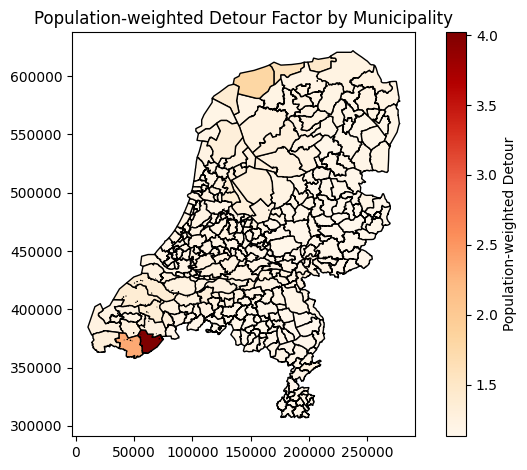

In [12]:

# --- 1. Read neighbourhood GeoPackage -----------------------------------
neigh_gdf = gpd.read_file(
    "data/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg"
)[[
    "buurtcode",       # neighbourhood code
    "gemeentecode",    # municipality code
    "gemeentenaam",    # municipality name
    "geometry"         # polygon geometry
]].copy()

# --- 2. Dissolve into municipalities ------------------------------------
#    All neighbourhood polygons with the same 'gemeentecode' are merged,
#    we keep the first 'gemeentenaam' value for each group.
mun_gdf = neigh_gdf.dissolve(
    by="gemeentecode",
    as_index=False,
    aggfunc={"gemeentenaam":"first"}
).rename(columns={
    "gemeentecode" : "municipality_code",
    "gemeentenaam" : "municipality_name"
})

# --- 3. Compute municipality-level detour -------------------------------
#    Weighted by population from your df (which has columns
#    'omrijdfactor', 'a_inw', and 'gm_naam').
mun_detour = (
    df
    .groupby("gm_naam")
    .apply(lambda g: (g["omrijdfactor"] * g["a_inw"]).sum()
                      / g["a_inw"].sum())
    .rename("popw_detour")
    .reset_index()
    .rename(columns={"gm_naam":"municipality_name"})
)

# --- 4. Merge detour values into municipal GeoDataFrame -----------------
mun_gdf = mun_gdf.merge(
    mun_detour,
    on="municipality_name",
    how="left"
)

# --- 5. Plot choropleth -------------------------------------------------
ax = mun_gdf.plot(
    column="popw_detour",
    cmap="OrRd",
    legend=True,
    edgecolor="black",
    legend_kwds={"label":"Population-weighted Detour"}
)
ax.set_title("Population-weighted Detour Factor by Municipality")
ax.set_axis_off()

plt.tight_layout()
plt.savefig("results/municipality_detour_map.png", dpi=1000, transparent=False)
plt.show()


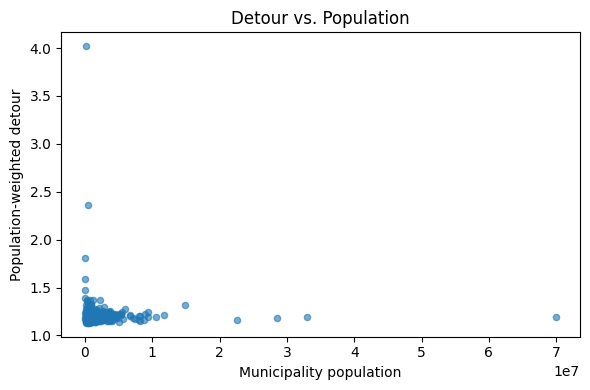

In [44]:
import matplotlib.pyplot as plt

mun_detour["total_population"] = df.groupby("gm_naam")["a_inw"].sum().values

ax = mun_detour.plot.scatter(
    x="total_population", y="popw_detour",
    alpha=0.6, figsize=(6,4)
)
ax.set_xlabel("Municipality population")
ax.set_ylabel("Population-weighted detour")
ax.set_title("Detour vs. Population")
plt.tight_layout()
plt.savefig("results/detour_vs_population.png", dpi=300, transparent=True)
plt.show()


In [26]:
cond = df["omrijdfactor"] > 1.3
affected = df[cond].groupby("gm_naam")["a_inw"].sum().sort_values(ascending=False)
print(affected.head(10))


gm_naam
Almere            5854530
Amsterdam         4549835
Zaanstad          2108865
Rotterdam         1956035
Dordrecht         1201165
Breda             1119375
Purmerend         1079180
Utrecht            976055
Haarlemmermeer     885740
Hoeksche Waard     780270
Name: a_inw, dtype: int64


## Look at population weighted detour with threshold of population

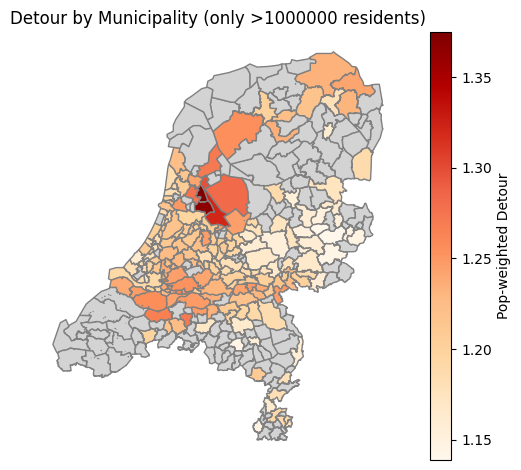

In [15]:
# Safely drop if it already exists
if "total_population" in mun_gdf.columns:
    mun_gdf = mun_gdf.drop(columns="total_population")

# Compute and merge population per municipality
pop_per_mun = df.groupby("gm_naam")["a_inw"].sum().reset_index()
pop_per_mun.columns = ["municipality_name", "total_population"]

mun_gdf = mun_gdf.merge(pop_per_mun, on="municipality_name", how="left")


# Set detour to NaN where population is below threshold
threshold = 1000000
mun_gdf["popw_detour_masked"] = mun_gdf["popw_detour"].where(
    mun_gdf["total_population"] > threshold
)


ax = mun_gdf.plot(
    column="popw_detour_masked",
    cmap="OrRd",
    legend=True,
    edgecolor="grey",
    missing_kwds={
        "color": "lightgrey",
        "label": f"Population ≤ {threshold}"
    },
    legend_kwds={"label": "Pop-weighted Detour"}
)
ax.set_title(f"Detour by Municipality (only >{threshold} residents)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("results/municipality_detour_masked.png", dpi=300, transparent=True)
plt.show()



## "What share of these residents already lives within 30 min e-bike time as-the-crow-flies but exceeds 30 min on the actual network?"

In [31]:
# ----------------------------------------------------------------------
# 4. Vraag 3 – ‘verborgen verliezers’ (≤30 min crow-fly, >30 min netwerk)
# ----------------------------------------------------------------------
df["t_crowfly_min"] = df["afstand_hemelsbreed_m"] / (25000 / 60)   # 25 km/h e-bike
mask_hidden = (df["t_crowfly_min"] <= 30) & (df["reistijd_min"] > 30)
hidden_pop = df.loc[mask_hidden].groupby("bu_code")["a_inw"].sum()
print(hidden_pop.head())

bu_code
BU00140000     8810
BU00140001    13140
BU00140002     8320
BU00140003     1700
BU00140004       20
Name: a_inw, dtype: int64


In [32]:
import geopandas as gpd

# Step 1 – Load neighbourhood GPKG
gdf_neigh = gpd.read_file("data/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg")[[
    "buurtcode", "gemeentecode", "gemeentenaam", "geometry"
]]

# Step 2 – Dissolve to municipality level
mun_gdf = gdf_neigh.dissolve(
    by="gemeentecode",
    as_index=False,
    aggfunc={"gemeentenaam": "first"}
).rename(columns={
    "gemeentecode": "municipality_code",
    "gemeentenaam": "municipality"
})


C:\Users\david\PycharmProjects\1bm110_data_driven_AI\.venv\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(


KeyError: 'hidden_population'

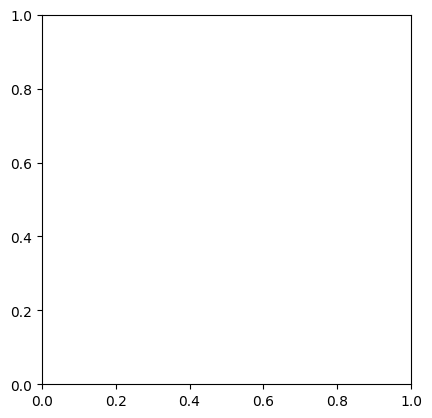

In [34]:
# Step 3 – Create hidden population per municipality (if not yet created)
mask_hidden = (df["t_crowfly_min"] <= 30) & (df["reistijd_min"] > 30)
hidden_by_mun = df.loc[mask_hidden].groupby("gm_naam")["a_inw"].sum().reset_index()
hidden_by_mun.columns = ["municipality", "hidden_population"]

# Step 4 – Merge and plot
mun_gdf = mun_gdf.merge(hidden_by_mun, on="municipality", how="left")

ax = mun_gdf.plot(
    column="hidden_population",
    cmap="YlOrBr",
    legend=True,
    edgecolor="grey",
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
ax.set_title("Residents within 30 min crow-fly but not via network")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("results/hidden_population_map.png", dpi=300, transparent=True)
plt.show()


In [18]:
# Total crow-fly reachable population per municipality
crowfly_by_mun = df[df["t_crowfly_min"] <= 30].groupby("gm_naam")["a_inw"].sum()

# Percentage hidden per municipality
share_hidden_by_mun = (hidden_by_mun
                       .set_index("municipality")["hidden_population"]
                       / crowfly_by_mun).dropna()

print(share_hidden_by_mun.sort_values(ascending=False).head(10))


Waalwijk            1.000000
Bergeijk            1.000000
Texel               1.000000
Sluis               1.000000
Nissewaard          1.000000
Noordoostpolder     1.000000
Ooststellingwerf    1.000000
Geertruidenberg     1.000000
Hulst               1.000000
Vaals               0.998102
dtype: float64


In [ ]:
hidden_top_buurten = df.loc[mask_hidden].groupby("bu_code")["a_inw"].sum().sort_values(ascending=False).head(10)
print(hidden_top_buurten)


In [ ]:


# ----------------------------------------------------------------------
# 3. Vraag 2 – inwoners per gemeente met detour > 1.3
# ----------------------------------------------------------------------
cond = df["omrijdfactor"] > 1.3
high_detour_pop = df.loc[cond].groupby("gm_naam")["a_inw"].sum()
print(high_detour_pop.sort_values(ascending=False).head())



# ----------------------------------------------------------------------
# 5. Vraag 4 – buurten met hoge detour én hoge trip-dichtheid
# ----------------------------------------------------------------------
trip_cnt   = df.groupby("bu_code").size().rename("trip_cnt")
summary    = pd.concat([pw_detour, trip_cnt], axis=1).dropna()
q_detour   = summary["pw_detour"].quantile(0.8)      # bovenste 20 %
q_trips    = summary["trip_cnt"].quantile(0.8)
candidates = summary[(summary["pw_detour"] > q_detour) & (summary["trip_cnt"] > q_trips)]
print(candidates.sort_values("pw_detour", ascending=False).head())

# ----------------------------------------------------------------------
# 6. Vraag 5 – scenario: detour >1.2 verlagen naar 1.15, bereik 30 min
# ----------------------------------------------------------------------
df["detour_adj"] = df["omrijdfactor"].where(df["omrijdfactor"] <= 1.2, 1.15)
df["t_new"]      = df["reistijd_min"] / df["omrijdfactor"] * df["detour_adj"]
reachable_new    = df[df["t_new"] <= 30].groupby("gm_naam")["a_inw"].sum()
print(reachable_new.sort_values(ascending=False).head())


In [11]:
import geopandas as gpd

# Pad naar jouw GeoPackage
gdf = gpd.read_file("data/WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg")


# Bekijk kolomnamen
print(gdf.columns)

# Merge met jouw detour-waarden
map_pw = gdf.merge(pw_detour, left_on="buurtcode", right_index=True)

# Sla op als GeoPackage voor gebruik in GIS / QGIS
map_pw.to_file("pw_detour.gpkg", layer="pw_detour", driver="GPKG")

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
C:\Users\david\AppData\Local\Temp\ipykernel_18112\2313164923.py:4: SyntaxWarning: invalid escape sequence '\w'
  gdf = gpd.read_file("data/WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg")
C:\Users\david\PycharmProjects\1bm110_data_driven_AI\.venv\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(


Index(['buurtcode', 'buurtnaam', 'wijkcode', 'gemeentecode', 'gemeentenaam',
       'indelingswijziging_wijken_en_buurten', 'water',
       'meest_voorkomende_postcode', 'dekkingspercentage',
       'omgevingsadressendichtheid',
       ...
       'afstand_tot_open_nat_natuurlijk_terrein',
       'afstand_tot_semiopenbaar_groen_totaal', 'afstand_tot_sportterrein',
       'afstand_tot_volkstuin', 'afstand_tot_verblijfsrecreatief_terrein',
       'afstand_tot_recreatief_binnenwater', 'afstand_tot_begraafplaats',
       'jrstatcode', 'jaar', 'geometry'],
      dtype='object', length=224)


In [13]:
import json
import numpy as np

def willingness_to_cycle(tij, location, mode="fiets", param_path=None):
    """
    Calculate the willingness to cycle based on travel time and location.

    Args:
        tij (float, array): Travel time in minutes.
        location (str): Location code.
        mode (str): One of "fiets" or "ebike. Default is "fiets".
    """
    if param_path is None:
        param_path = f"data/cycle_willingness/{mode}.json"

    with open(param_path, "r") as f:
        model_params = json.load(f)

    if location not in model_params:
        raise ValueError("Unknown location")

    a, b = model_params[location]
    F_ij = 1 / (1 + np.exp(a + b * np.log(tij + 1e-10)))

    return F_ij

In [14]:
from codebase.load_data.load_demographics import load_demograhics
from codebase.load_data.load_buurt        import load_buurt_data


# ------------------------------------------------------------------------
# A. Load & merge once, reuse everywhere
df_demo = load_demograhics()                         # CBS table (incl. a_inw, gm_naam …)
df_punt = load_buurt_data("trein", mode=MODE)        # O-D to rail stations (incl. reistijd_min …)

# If the column with station id is called something else, fix it here:
df_punt = df_punt.rename(columns={"station_id_column_in_file": "dest_station_id"})

# Add crow-fly travel time (needed for ‘hidden_mask’ later)
# 25 km/h assumed for e-bike → 25000 m per h ≈ (25000/60)m per min
df_punt["t_crowfly_min"] = df_punt["afstand_hemelsbreed_m"] / (25000/60)

# Merge demographics (many-to-one) – the helper you already used

df = safe_merge_multi(df_punt, df_demo)
# ------------------------------------------------------------------------


Loaded file from Excel and saved to CSV


NameError: name 'MODE' is not defined

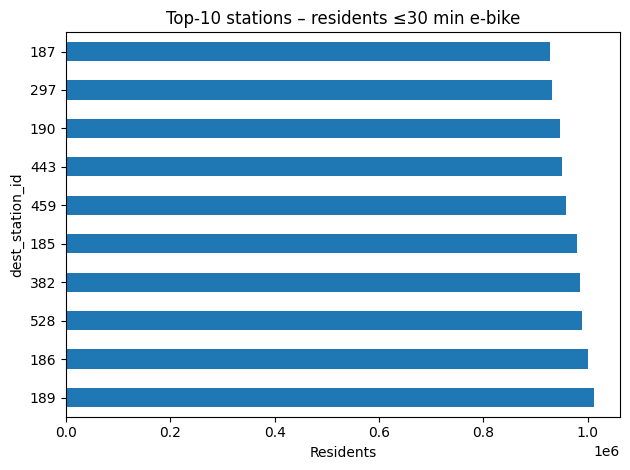

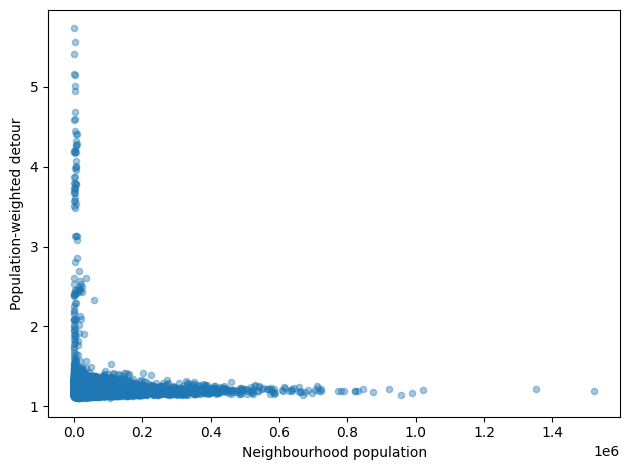

C:\Users\david\PycharmProjects\1bm110_data_driven_AI\.venv\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(


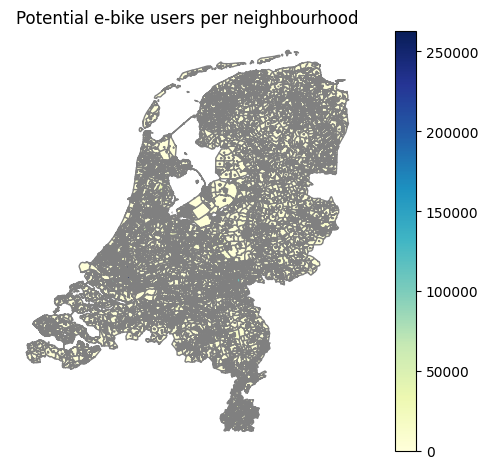

QC: NL population totals roughly match (after dedup)


In [11]:
# -----------------------------  CONFIG  ---------------------------------
OUTDIR   = "results"                       # all CSV/figures end up here
LOCATION = "Education"                     # valid key in ebike.json
MODE     = "ebike"                         # "fiets" or "ebike"
GPKG     = "data/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg"
# ------------------------------------------------------------------------

import os, pandas as pd, matplotlib.pyplot as plt, geopandas as gpd


os.makedirs(OUTDIR, exist_ok=True)

# ------------------------------------------------------------------------
# 0.  COLUMN ALIASES  (make sure we do not duplicate)
# ------------------------------------------------------------------------
if "dest_station_id" not in df.columns and "train_id" in df.columns:
    df = df.rename(columns={"train_id"     : "dest_station_id"})
if "t_ebike_min"   not in df.columns and "reistijd_min" in df.columns:
    df = df.rename(columns={"reistijd_min" : "t_ebike_min"})

df = df.loc[:, ~df.columns.duplicated()]     # drop accidental dups
# ------------------------------------------------------------------------



# ========== 2. ACCESSIBILITY INDICATORS (≤30 min e-bike) ================
within30   = df[df["t_ebike_min"] <= 30]
pop_in_30  = within30.groupby("dest_station_id")["a_inw"].sum()
share_30   = pop_in_30 / df_demo["a_inw"].sum()     # national total
tbl_access = pd.concat([pop_in_30, share_30.rename("share_30")], axis=1)
tbl_access.to_csv(f"{OUTDIR}/station_pop30.csv")

# ========== 3. WILLINGNESS TRANSLATION  =================================
df["p_time"]    = willingness_to_cycle(df["t_ebike_min"],
                                       location=LOCATION, mode=MODE)
df["potential"] = df["a_inw"] * df["p_time"]

pot_sta  = df.groupby("dest_station_id")["potential"].sum()
pot_buur = df.groupby("bu_code")["potential"].sum()
pot_sta.to_csv (f"{OUTDIR}/station_potential_users.csv")
pot_buur.to_csv(f"{OUTDIR}/buurt_potential_users.csv")

# ========== 4. NETWORK-EFFICIENCY FLAGS  ===============================
mean_det = (df["omrijdfactor"] * df["a_inw"]).groupby(df["bu_code"]).sum() \
           / df.groupby("bu_code")["a_inw"].sum()

hidden_mask = (df["t_crowfly_min"] <= 30) & (df["t_ebike_min"] > 30)
hidden_pop  = df.loc[hidden_mask].groupby("bu_code")["a_inw"].sum()
hidden_pop[hidden_pop > 0].to_csv(f"{OUTDIR}/hidden_losers.csv")

# ========== 5. KPI-MATRIX PER GEMEENTE =================================
kpi = df.groupby("gm_naam").agg(
        pop_in_30 = ('a_inw',
                     lambda s, df=df: s[df.loc[s.index, "t_ebike_min"] <= 30].sum()),
        potential = ('potential', 'sum'),
        mean_det  = ('omrijdfactor',
                     lambda s, df=df: (s * df.loc[s.index, "a_inw"]).sum()
                                      / df.loc[s.index, "a_inw"].sum())
)
kpi.to_csv(f"{OUTDIR}/kpi_gemeente.csv")

#Focus on gemeente with highest mean_det and most inhabitants

# ========== 5a. KPI-MATRIX PER BUURT ==================================


# ========== 6. BASIC VISUALS  ==========================================
# 6a Bar chart – top-10 stations by reachable pop
top10 = tbl_access.nlargest(10, "a_inw")
top10["a_inw"].plot(kind="barh")
plt.title("Top-10 stations – residents ≤30 min e-bike")
plt.xlabel("Residents")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/bar_top10_stations.png", dpi=300)
plt.show()


# 6b Scatter – neighbourhood pop vs. mean detour
scatter_df = mean_det.to_frame("mean_det").merge(
    df.groupby("bu_code")["a_inw"].sum(), left_index=True, right_index=True
)
scatter_df.plot.scatter(x="a_inw", y="mean_det", alpha=0.4)
plt.xlabel("Neighbourhood population")
plt.ylabel("Population-weighted detour")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/scatter_pop_vs_detour.png", dpi=300)
plt.show()


# 6c Choropleth – potential users
gdf = gpd.read_file(GPKG)[["buurtcode", "geometry"]]
gdf = gdf.merge(pot_buur.rename("potential"), left_on="buurtcode", right_index=True)
gdf.plot(column="potential", cmap="YlGnBu", legend=True, edgecolor="grey")
plt.title("Potential e-bike users per neighbourhood")
plt.axis("off")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/map_potential_users.png", dpi=300)
plt.show()


# ========== 7. (optional) PCA etc. =====================================
# ... leave False unless you actually want it ...

# ========== 8. VALIDATION  =============================================
# ---------------- QC: correcte bevolkings-teller -----------------
# haal uitsluitend de nationale totaalrij ('NL00')
pop_cbs = df_demo.loc[df_demo["gwb_code"] == "NL00", "a_inw"].iloc[0]

pop_df   = df[["bu_code", "a_inw"]].drop_duplicates()
pop_fact = pop_df["a_inw"].sum()

assert abs(pop_fact - pop_cbs) / 1e6 < 0.1, \
       f"Pop mismatch {abs(pop_fact-pop_cbs):,.0f}"
print("QC: NL population totals roughly match (after dedup)")




In [41]:
#focus with highest mean_det
kpi.sort_values("mean_det", ascending=False, inplace=True)

#highest highest mean_det with most inhabitants
print(kpi.nlargest(10, "mean_det"))


                    pop_in_30      potential  mean_det
gm_naam                                               
Hulst                       0      54.165980  4.019760
Terneuzen                   0     219.847969  2.358002
Terschelling                0       0.236252  1.806423
Ameland                     0       5.722796  1.588582
Schiermonnikoog             0       2.443958  1.472109
Vlieland                    0       0.053167  1.394190
Edam-Volendam          101630  147988.379178  1.374695
Goeree-Overflakkee          0   14328.258998  1.371011
Schouwen-Duiveland          0    9314.868290  1.368425
Waterland               39385   88444.455906  1.366939


In [38]:
print(df.columns.tolist())


['train_id', 'bu_code', 'reistijd_min', 'reisafstand_m', 'afstand_hemelsbreed_m', 'omrijdfactor', 't_crowfly_min', 'gwb_code', 'a_inw', 'gm_naam']


In [39]:
import json

with open("data/cycle_willingness/ebike.json") as f:
    params = json.load(f)

print(list(params.keys()))


['Work', 'Shop', 'Education', 'Recreation', 'Tour', 'Urban_1', 'Urban_2', 'Urban_3', 'Urban_4', 'Urban_5']


In [50]:
import os
print(os.listdir())  # toont bestanden in je huidige map




['.git', '.gitattributes', '.gitignore', '.idea', 'codebase', 'data', 'graphics', 'high_detour_pct.csv', 'pw_detour.gpkg', 'pw_detour_map.png', 'requirements.txt', 'results', 'test.py', 'Topic1', 'Topic2', 'Topic3']
